In [5]:
from gensim.models import Phrases
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore

import os
import codecs
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle
import pandas as pd
import numpy as np
import itertools

In [7]:
import spacy
import nltk
import nltk.classify.util
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords, names

nlp = spacy.load('en')

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
data = pd.read_csv("data.csv", encoding='ISO-8859-1')
np.shape(data) #(2043401, 27)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,6,11,12,13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2043401, 27)

In [84]:
data = data.drop('Unnamed: 0', 1)

In [85]:
data.head()

,funny,user_id,review_id,text,business_id,stars,date,useful,cool,yelping_since,...,state,postal_code,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif
0,0,kzyLOqiJvyw_FWFTw2rjiQ,ByRzJ8rF2KJWLr-cUNU6EA,"This place is horrible, we were so excited to ...",jQsNFOzDpxPmOurSWCg1vQ,1,2017-06-03,0.0,0.0,2016-06-17,...,AZ,85374.0,33.638228,-112.365,3.5,92.0,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-2.00,-2.5
1,0,WZXp9-V2dqRRJqhGgRqueA,i5UwUPlQFPLcE8p2gPFwBw,"For being fairly ""fast"" food.. Pei Wei (pronou...",jQsNFOzDpxPmOurSWCg1vQ,4,2015-03-26,1.0,0.0,2012-09-28,...,AZ,85374.0,33.638228,-112.365,3.5,92.0,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",0.46,0.5
2,1,XylT12exfdLiI_3uDLVIpw,EyQyvTTg2jX4or9bB8PC9g,"I decided to try it out, I'm celiac and theref...",jQsNFOzDpxPmOurSWCg1vQ,5,2012-12-30,2.0,1.0,2010-10-19,...,AZ,85374.0,33.638228,-112.365,3.5,92.0,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",0.96,1.5
3,1,Ji9PeffxjwqPLO7pEfSpKQ,G-EFA005besj5uHsH0sQFA,I'm not saying Pei Wei is the best asian food ...,jQsNFOzDpxPmOurSWCg1vQ,3,2009-01-12,1.0,1.0,2008-11-20,...,AZ,85374.0,33.638228,-112.365,3.5,92.0,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-0.55,-0.5
4,0,TLIWzAJPrET0zX4_vgvLhg,6PcJSGUBSLjt4VLXos5C4A,Sometimes the food is spot on and delicious an...,jQsNFOzDpxPmOurSWCg1vQ,3,2015-07-11,0.0,0.0,2014-08-03,...,AZ,85374.0,33.638228,-112.365,3.5,92.0,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-0.55,-0.5


In [86]:
def textPreProcess(reviews_column):
    
    filtered = []
    temp = []
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))

    for review in reviews_column:
        words = tokenizer.tokenize(review)
        for w in words:
            if w.lower() not in stop_words:
                temp.append(w.lower())
        filtered.append(temp)
        temp = []

    return filtered

In [87]:
filtered = textPreProcess(data['text'])

In [88]:
def sentimentScore(data, filtered):
    
    neg_file = open("negative-words.txt", "r")
    neg_dict = neg_file.read().split('\n')
    neg_file.close()

    pos_file = open("positive-words.txt", "r")
    pos_dict = pos_file.read().split('\n')
    pos_file.close()
        
    pos_counter = 0
    neg_counter = 0
    sent_ratio = 0
    sentiment_score = []
    
    for review in filtered:
        for word in review:
            if word in pos_dict:
                pos_counter = pos_counter + 1
            if word in neg_dict:
                neg_counter = neg_counter + 1
                
        if len(review) != 0:
            sent_ratio = float(pos_counter - neg_counter) / float(len(review))  
        else:
            sent_ratio = 0
        sentiment_score.append(sent_ratio)
        pos_counter = 0
        neg_counter = 0
    
    df = pd.DataFrame(np.column_stack([filtered, sentiment_score]), columns=['filtered_text', 'sentiment_score'])
    
    # reset indexes to zero so pd.concat works properly
    data.index = (range(0, len(data)))
    df.index = (range(0, len(df)))
    return pd.concat([data, df], axis=1)

In [89]:
%%time
scored_df = sentimentScore(data, filtered)

Wall time: 2h 40min 25s


In [ ]:
scored_df.to_csv('scored_df.csv')

In [202]:
scored_df = pd.read_csv("scored_df.csv", encoding='ISO-8859-1')
np.shape(scored_df) #(2043401, 29)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,6,11,12,13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2043401, 29)

In [185]:
corr_df = scored_df.loc[:,['stars', 'sentiment_score']]

In [204]:
scored_df = scored_df.dropna(subset=['stars'])

In [205]:
scored_df = scored_df[scored_df.stars != '2013-06-30']

In [203]:
scored_df = scored_df.drop('Unnamed: 0', 1)

In [235]:
scored_df['average_stars'] = scored_df['average_stars'].apply(float)

In [236]:
scored_df['average_stars'].mean()

3.752122820847011

In [232]:
scored_df.describe()

,stars,useful,cool,postal_code,latitude,business_avg_stars,review_count_y,is_open,stars_dif,bus_stars_dif,sentiment_score
count,2.043399e+06,2.043399e+06,2.043399e+06,2.042974e+06,2.043399e+06,2.043399e+06,2.043399e+06,2043399.0,2.043399e+06,2.043399e+06,2.043399e+06
mean,3.748968e+00,9.164417e-01,5.244375e-01,7.397933e+04,3.598662e+01,3.751935e+00,5.253172e+02,1.0,-3.154558e-03,-2.966381e-03,1.053997e-01
std,1.358269e+00,2.498583e+00,2.101433e+00,2.428910e+04,2.666742e+00,5.842759e-01,8.720526e+02,0.0,1.166744e+00,1.243536e+00,1.075339e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,2.224000e+03,3.313739e+01,1.000000e+00,3.000000e+00,1.0,-3.910000e+00,-4.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,8.500300e+04,3.353931e+01,3.500000e+00,1.030000e+02,1.0,-6.700000e-01,-1.000000e+00,3.773585e-02
50%,4.000000e+00,0.000000e+00,0.000000e+00,8.526000e+04,3.606815e+01,4.000000e+00,2.480000e+02,1.0,1.100000e-01,5.000000e-01,9.722222e-02
75%,5.000000e+00,1.000000e+00,0.000000e+00,8.910900e+04,3.614495e+01,4.000000e+00,5.610000e+02,1.0,8.200000e-01,1.000000e+00,1.666667e-01
max,5.000000e+00,2.510000e+02,2.310000e+02,9.802300e+04,4.650400e+01,5.000000e+00,6.979000e+03,1.0,3.850000e+00,4.000000e+00,1.000000e+00


In [208]:
scored_df.groupby('stars').count()

,funny,user_id,review_id,text,business_id,date,useful,cool,yelping_since,review_count_x,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
stars,,,,,,,,,,,,,,,,,,,,,
1,228344,228344,228344,228344,228344,228344,228344,228344,228344,228344,...,228344,228344,228344,228344,228344,228344,228344,228344,228344,228344
2,190147,190147,190147,190147,190147,190147,190147,190147,190147,190147,...,190147,190147,190147,190147,190147,190147,190147,190147,190147,190147
3,265286,265286,265286,265286,265286,265286,265286,265286,265286,265286,...,265286,265286,265286,265286,265286,265286,265286,265286,265286,265286
4,541968,541968,541968,541968,541968,541968,541968,541968,541968,541968,...,541968,541968,541968,541968,541968,541968,541968,541968,541968,541968
5,817654,817654,817654,817654,817654,817654,817654,817654,817654,817654,...,817654,817654,817654,817654,817654,817654,817654,817654,817654,817654


In [207]:
scored_df['stars'] = scored_df['stars'].apply(int)

In [212]:
print(scored_df['stars'].corr(scored_df['sentiment_score']))
print(scored_df['stars_dif'].corr(scored_df['sentiment_score']))

0.567907522791
0.454066529438


In [240]:
distplot3 = scored_df.loc[:,['sentiment_score', 'stars_dif', 'stars']]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


(-4, 2)

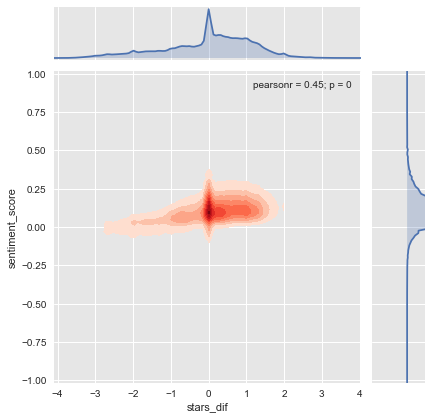

In [242]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.jointplot(distplot3.stars_dif, distplot3.sentiment_score, kind = 'kde', cmap="Reds", shade=True, shade_lowest=False)
#sns.plt.ylim(-0.25,0)
sns.plt.xlim((-4),2)

In [239]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.jointplot(distplot3.stars, distplot3.sentiment_score, kind = 'kde', cmap="Reds", shade=True, shade_lowest=False)
#sns.plt.ylim(-0.25,0)
sns.plt.xlim((-4),2)

AttributeError: 'DataFrame' object has no attribute 'stars'

In [221]:
import scipy as sp
from scipy import stats
sp.stats.spearmanr(scored_df['stars'], scored_df['sentiment_score'])

SpearmanrResult(correlation=0.57184624524878747, pvalue=0.0)

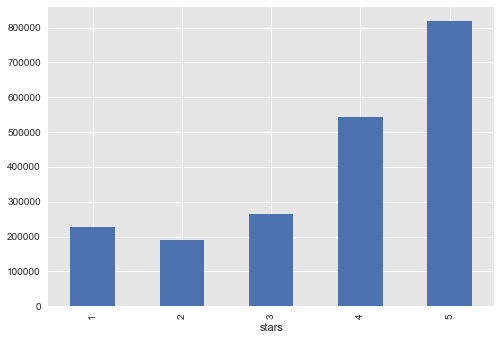

In [225]:
bar_df = scored_df.groupby('stars')['is_open'].sum()
bar_df.plot.bar()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


(-0.4, 0.4)

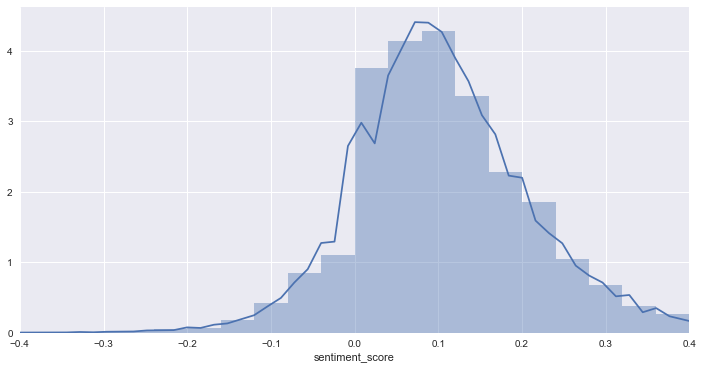

In [217]:
plt.figure(figsize=(12,6))
sns.distplot(scored_df['sentiment_score'], label='Sentiment Score')
sns.plt.xlim(-0.4,0.4)

In [90]:
#scored_df = pd.read_csv("scored_df.csv", encoding='ISO-8859-1')
neg_scores = scored_df[scored_df['sentiment_score'] < 0]
np.shape(neg_scores) 

(223487, 28)

In [106]:
neg_scores['stars'] = neg_scores['stars'].apply(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [222]:
print(sp.stats.spearmanr(neg_scores['stars'], neg_scores['sentiment_score']))
print(sp.stats.spearmanr(neg_scores['stars_dif'], neg_scores['sentiment_score']))

SpearmanrResult(correlation=0.14814724011469252, pvalue=0.0)
SpearmanrResult(correlation=0.046634209769850277, pvalue=8.0176788335912573e-108)


In [110]:
neg_scores.describe()

,stars,useful,cool,postal_code,latitude,business_avg_stars,review_count_y,is_open,stars_dif,bus_stars_dif
count,223487.000000,223487.000000,223487.000000,223443.000000,223487.000000,223487.000000,223487.000000,223487.0,223487.000000,223487.000000
mean,1.863621,0.961161,0.308461,74167.992625,36.005608,3.370149,432.892092,1.0,-1.292197,-1.506528
std,1.166688,2.203870,1.449252,24142.488977,2.647408,0.698158,790.342587,0.0,1.164313,1.164704
min,1.000000,0.000000,0.000000,2224.000000,33.137390,1.000000,3.000000,1.0,-3.890000,-4.000000
25%,1.000000,0.000000,0.000000,85003.000000,33.567812,3.000000,67.000000,1.0,-2.190000,-2.500000
50%,1.000000,0.000000,0.000000,85281.000000,36.072381,3.500000,178.000000,1.0,-1.440000,-1.500000
75%,2.000000,1.000000,0.000000,89109.000000,36.148619,4.000000,435.000000,1.0,-0.360000,-1.000000
max,5.000000,251.000000,168.000000,98023.000000,44.992140,5.000000,6979.000000,1.0,3.560000,3.500000


(array([  4.07000000e+02,   2.76300000e+03,   9.00700000e+03,
          1.20450000e+04,   1.76710000e+04,   1.92010000e+04,
          2.43140000e+04,   2.03640000e+04,   2.10600000e+04,
          1.62360000e+04,   1.47790000e+04,   1.16180000e+04,
          7.12200000e+03,   2.74620000e+04,   6.31700000e+03,
          4.41200000e+03,   3.61600000e+03,   2.53100000e+03,
          1.34000000e+03,   6.99000000e+02,   2.83000000e+02,
          1.28000000e+02,   7.30000000e+01,   2.80000000e+01,
          1.10000000e+01]),
 array([-3.89 , -3.592, -3.294, -2.996, -2.698, -2.4  , -2.102, -1.804,
        -1.506, -1.208, -0.91 , -0.612, -0.314, -0.016,  0.282,  0.58 ,
         0.878,  1.176,  1.474,  1.772,  2.07 ,  2.368,  2.666,  2.964,
         3.262,  3.56 ]),
 <a list of 25 Patch objects>)

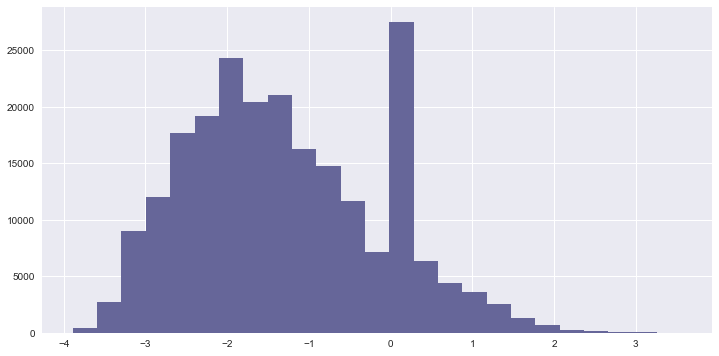

In [70]:
plt.figure(figsize=(12,6))
plt.hist(neg_scores['stars_dif'], bins=25, color="#666699")  #.dropna(axis=0, how='any')

(array([  7.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          6.00000000e+00,   2.30000000e+01,   7.00000000e+00,
          7.90000000e+01,   7.70000000e+01,   1.22000000e+02,
          3.75000000e+02,   5.37000000e+02,   9.45000000e+02,
          1.88900000e+03,   2.79700000e+03,   7.60200000e+03,
          1.41430000e+04,   3.19980000e+04,   6.82080000e+04,
          9.46560000e+04]),
 array([-1.        , -0.96007968, -0.92015936, -0.88023904, -0.84031873,
        -0.80039841, -0.76047809, -0.72055777, -0.68063745, -0.64071713,
        -0.60079681, -0.56087649, -0.52095618, -0.48103586, -0.44111554,
        -0.40119522, -0.3612749 , -0.32135458, -0.28143426, -0.24151394,
        -0.20159363, -0.16167331, -0.12175299, -0.08183267, -0.04191235,
        -0.00199203]),
 <a list of 25 Patch objects>)

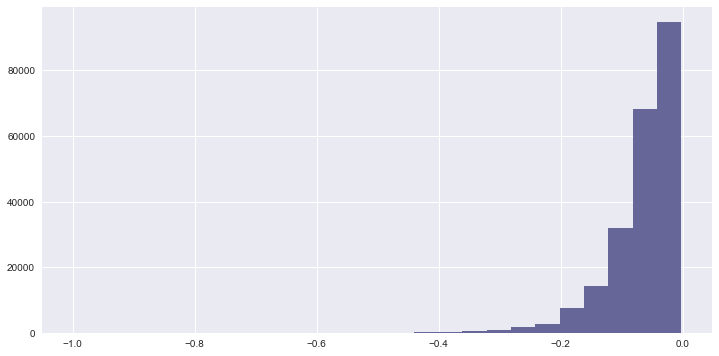

In [69]:
plt.figure(figsize=(12,6))
plt.hist(neg_scores['sentiment_score'], bins=25, color="#666699")  #.dropna(axis=0, how='any')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


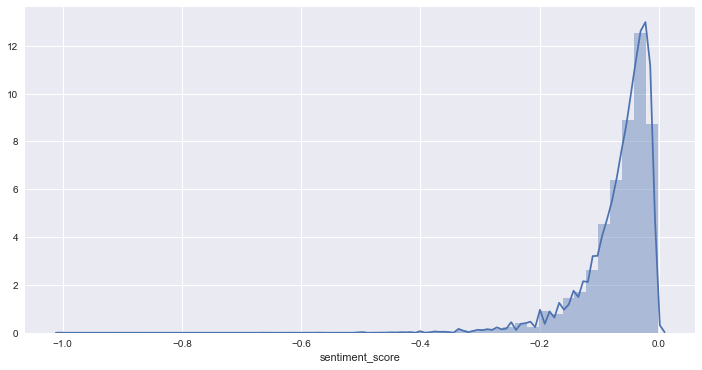

In [71]:
plt.figure(figsize=(12,6))
sns.distplot(neg_scores['sentiment_score'], label='Sentiment Score')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


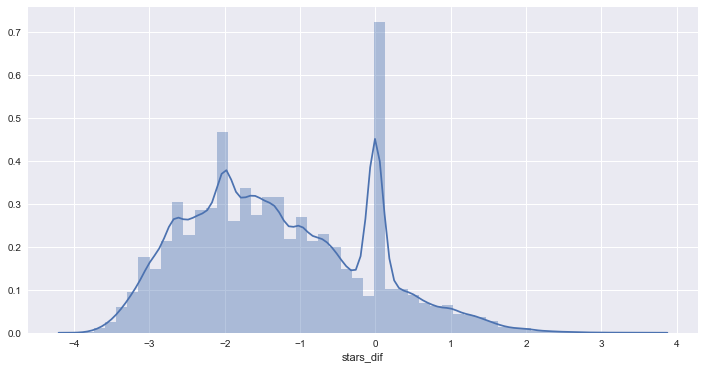

In [72]:
plt.figure(figsize=(12,6))
sns.distplot(neg_scores['stars_dif'], label='Stars_Dif')

In [124]:
from sklearn import preprocessing
standardizer = lambda x: (2 * ((x - min(x)) / (max(x) - min(x))) - 1)

In [118]:
distplot.shape

(223487, 3)

In [128]:
distplot['stars_norm'] = distplot[['stars_dif']].apply(standardizer, axis=0)

In [129]:
distplot.head()

,sentiment_score,stars_dif,stars_norm
0,-0.033333,-2.67,-0.672483
1,-0.040000,-2.13,-0.527517
2,-0.040000,-0.48,-0.084564
3,-0.022989,-1.63,-0.393289
4,-0.057692,-1.21,-0.280537


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


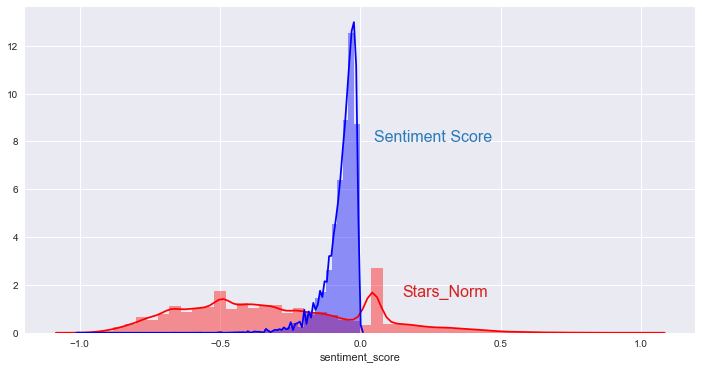

In [138]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(12,6))
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.distplot(distplot['stars_norm'], color="r")
ax = sns.distplot(distplot['sentiment_score'], color="b")

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(0.05, 8.0, "Sentiment Score", size=16, color=blue)
ax.text(0.15, 1.5, "Stars_Norm", size=16, color=red)

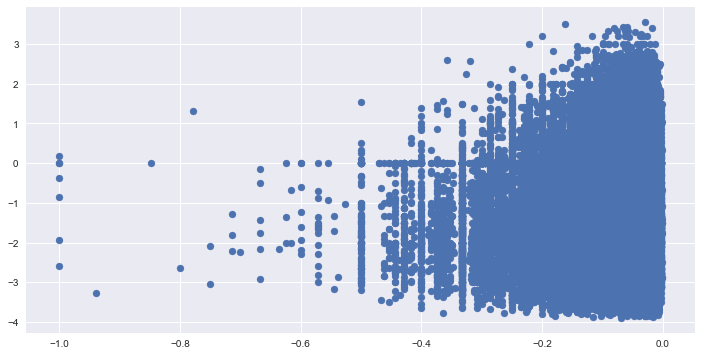

In [150]:
plt.figure(figsize=(12,6))
plt.scatter(neg_scores['sentiment_score'], neg_scores['stars_dif'])

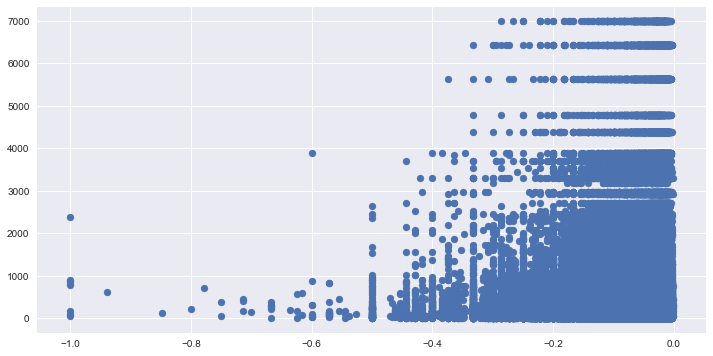

In [145]:
plt.figure(figsize=(12,6))
plt.scatter(neg_scores['sentiment_score'], neg_scores['review_count_y'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


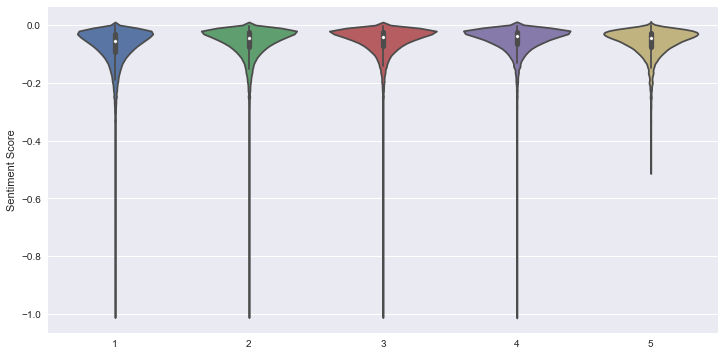

In [79]:
plt.figure(figsize=(12,6))
sns.violinplot(x='stars', y='sentiment_score', data=neg_scores).set(xlabel='', ylabel='Sentiment Score')

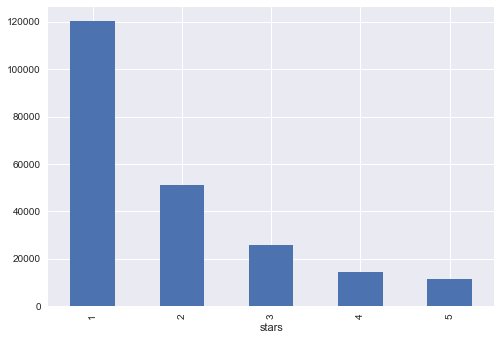

In [153]:
bar_df = neg_scores.groupby('stars')['is_open'].sum()
bar_df.plot.bar()

In [99]:
distplot = neg_scores.loc[:,['sentiment_score', 'stars_dif']]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


(-4, 2)

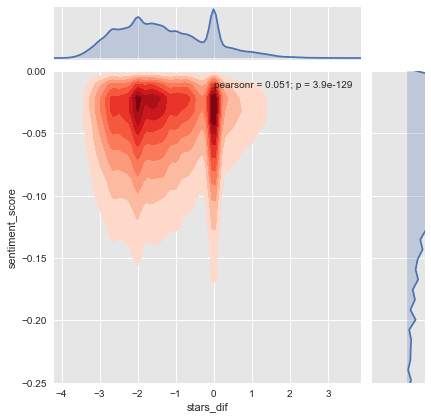

In [224]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.jointplot(distplot.stars_dif, distplot.sentiment_score, kind = 'kde', cmap="Reds", shade=True, shade_lowest=False)
sns.plt.ylim(-0.25,0)
sns.plt.xlim((-4),2)

In [109]:
neg_scores.columns.tolist()

['funny',
 'user_id',
 'review_id',
 'text',
 'business_id',
 'stars',
 'date',
 'useful',
 'cool',
 'yelping_since',
 'review_count_x',
 'fans',
 'average_stars',
 'name',
 'neighborhood',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'business_avg_stars',
 'review_count_y',
 'is_open',
 'categories',
 'stars_dif',
 'bus_stars_dif',
 'filtered_text',
 'sentiment_score']

In [108]:
neg_scores.groupby('stars').count()

,funny,user_id,review_id,text,business_id,date,useful,cool,yelping_since,review_count_x,...,latitude,longitude,business_avg_stars,review_count_y,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score
stars,,,,,,,,,,,,,,,,,,,,,
1,120180,120180,120180,120180,120180,120180,120180,120180,120180,120180,...,120180,120180,120180,120180,120180,120180,120180,120180,120180,120180
2,51259,51259,51259,51259,51259,51259,51259,51259,51259,51259,...,51259,51259,51259,51259,51259,51259,51259,51259,51259,51259
3,25980,25980,25980,25980,25980,25980,25980,25980,25980,25980,...,25980,25980,25980,25980,25980,25980,25980,25980,25980,25980
4,14483,14483,14483,14483,14483,14483,14483,14483,14483,14483,...,14483,14483,14483,14483,14483,14483,14483,14483,14483,14483
5,11585,11585,11585,11585,11585,11585,11585,11585,11585,11585,...,11585,11585,11585,11585,11585,11585,11585,11585,11585,11585


In [102]:
type(neg_scores['stars'].iloc[223486])

int

In [111]:
neg_scores.to_csv('neg_scores.csv')

In [7]:
neg_scores = pd.read_csv("neg_scores.csv", encoding='ISO-8859-1')

In [9]:
# helper functions for text preprocessing & LDA modeling:

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space or token.like_num or token.is_digit

def line_review(filename):
    """
    generator function to read in reviews from Pandas Series
    and un-escape the original line breaks in the text
    """
    
    #with codecs.open(filename, encoding='utf_8') as f:
    for review in filename:
        yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    # load finished dictionary from disk
    trigram_dictionary = Dictionary.load('./models/trigram_dict_all_neg.dict')
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [24]:
def reviewPreProcess(text):
    """
    Takes Pandas series as input,
    consisting of one review as 
    text string per row
    """
    
    # lemmatized_sentence_corpus generator loops over original review text, segments the reviews into individual sentences 
    # and normalizes text. Writes data to new file with one normalized sentence per line:
    with codecs.open('./models/unigram_sentences_neg.txt', 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(text):  
            f.write(sentence + '\n')
    
    # Create object to stream unigram sentences from disk, rather than hold in memory:
    unigram_sentences = LineSentence('./models/unigram_sentences_neg.txt')
        
    # Train phrase model to link individual words into two-word phrases: 
    bigram_model = Phrases(unigram_sentences)
    bigram_model.save('./models/bigram_model_neg.txt')
            
    # Apply trained bigram phrase model to the review sentences data: 
    with codecs.open('./models/bigram_sentences_neg.txt', 'w', encoding='utf_8') as f:
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')
    
    # Create object to stream bigram sentences from disk, rather than hold in memory:
    bigram_sentences = LineSentence('./models/bigram_sentences_neg.txt')
    
    # Train second-order phrase model to to generate trigrams:
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save('./models/trigram_model_neg.txt')
    
    # Apply trained second-order phrase model to our first-order transformed sentences and write to a new file:
    #with codecs.open('./models/trigram_sentences_neg.txt', 'w', encoding='utf_8') as f:
    #    for bigram_sentence in bigram_sentences:
    #        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
    #        f.write(trigram_sentence + '\n')
    
    # Run complete text of the reviews through a pipeline that applies text normalization and phrase models.
    # Also remove stopwords and write transformed text to a new file, one review per line:
    with codecs.open('./models/trigram_transformed_reviews_neg.txt', 'w', encoding='utf_8') as f:
        for parsed_review in nlp.pipe(line_review(text), 
                                        batch_size=10000, n_threads=4):
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                                if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
                
            common_terms = ['order', 'come', 'bad', 'good', \
                            'place', 'time', '\'s'] #'service', 
                
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                                if term not in spacy.en.English.Defaults.stop_words]
            trigram_review = [term for term in trigram_review
                                if term not in common_terms]
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')
    
    
    # Learn full vocabulary of corpus to be modeled, using gensim's Dictionary class.  Stream
    # reviews off of disk using LineSentence:
    trigram_reviews = LineSentence('./models/trigram_transformed_reviews_neg.txt')

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save('./models/trigram_dict_all_neg.dict')
    
    return bigram_model, trigram_model, trigram_dictionary
 

In [25]:
def LDA_Model(topics, cores=3):
    """
    Topics represents desired LDA topics,
    cores should be physical cores minus one. 
    Both should be integers.
    """
    
    # load finished dictionary from disk
    trigram_dictionary = Dictionary.load('./models/trigram_dict_all_neg.dict')
        
    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize('./models/trigram_bow_corpus_neg.nm',
                        trigram_bow_generator('./models/trigram_transformed_reviews_neg.txt'))
    
    # load finished bag-of-words corpus from disk
    trigram_bow_corpus = MmCorpus('./models/trigram_bow_corpus_neg.nm')
    
    
    # Pass the bag-of-words matrix and Dictionary from previous steps to LdaMulticore as inputs, 
    # along with the number of topics the model should learn
        
    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(trigram_bow_corpus, 
                       num_topics=topics, 
                       id2word=trigram_dictionary, 
                       workers=cores)
        
    lda.save('./models/lda_model_neg')
        
    # load the finished LDA model from disk
    #lda = LdaMulticore.load('./models/lda_model_neg')
    
    return trigram_bow_corpus, lda


In [26]:
%%time
bigram_model, trigram_model, trigram_dictionary = reviewPreProcess(neg_scores['text'])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Wall time: 19min 11s


In [27]:
%%time
trigram_bow_corpus, lda = LDA_Model(3)

Wall time: 2min


In [13]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [28]:
explore_topic(topic_number=0)

term                 frequency

eat                  0.013
like                 0.011
taste                0.010
chicken              0.010
service              0.008
$                    0.006
try                  0.006
fry                  0.006
restaurant           0.006
meat                 0.005
dish                 0.005
sauce                0.005
pizza                0.005
meal                 0.005
cold                 0.005
bland                0.005
salad                0.005
think                0.005
burger               0.005
flavor               0.004
look                 0.004
cheese               0.004
dry                  0.004
star                 0.004
sandwich             0.004


In [29]:
explore_topic(topic_number=1)

term                 frequency

$                    0.011
restaurant           0.009
try                  0.008
service              0.007
like                 0.007
want                 0.006
menu                 0.006
price                0.006
drink                0.006
think                0.006
bar                  0.005
know                 0.005
people               0.004
eat                  0.004
thing                0.004
vegas                0.004
find                 0.004
charge               0.004
tell                 0.004
day                  0.004
ask                  0.003
way                  0.003
great                0.003
look                 0.003
buffet               0.003


In [30]:
explore_topic(topic_number=2)

term                 frequency

service              0.019
wait                 0.016
ask                  0.015
table                0.014
minute               0.012
tell                 0.011
manager              0.009
server               0.009
customer             0.008
drink                0.008
want                 0.007
leave                0.007
restaurant           0.007
people               0.006
experience           0.006
waitress             0.006
eat                  0.006
know                 0.006
sit                  0.006
seat                 0.005
like                 0.005
rude                 0.005
check                0.005
walk                 0.005
staff                0.005


In [18]:
# Assign topic names and save to disk:
topic_names = {0: u'food_quality',
               1: u'price',
               2: u'service_quality'}

#with open('./models/topic_names.pkl', 'wb') as f:
    #pickle.dump(topic_names, f)

In [50]:
# Prepare for LDA visualization

trigram_dictionary = Dictionary.load('./models/trigram_dict_all_neg.dict')

In [32]:
lda = LdaMulticore.load('./models/lda_model_neg')
    
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)

# Save pre-prepared pyLDAvis data to disk:
with open('./models/ldavis_prepared', 'wb') as f: 
    pickle.dump(LDAvis_prepared, f)
    
# load the pre-prepared pyLDAvis data from disk:
with open('./models/ldavis_prepared', 'rb') as f:  
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.display(LDAvis_prepared)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


In [62]:
pyLDAvis.save_html(LDAvis_prepared, './models/ldavis_html')

In [10]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    
    return list(it.islice(line_review(neg_scores['text']),
                          review_number, review_number+1))[0]

In [2]:
# for description of single review text

def lda_description(review_text, min_topic_freq=0):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in spacy.en.English.Defaults.stop_words]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]
    
    # sort with the most highly related topics first
    #review_lda = sorted(review_lda, key=lambda (topic_number, freq): -freq)  # was: key=lambda (topic_number, freq): -freq) ???
    
    for topic_number, freq in review_lda:
        if freq < min_topic_freq:
            break
            
        # print the most highly related topic names and frequencies
        print('{:25} {}'.format(topic_names[topic_number], round(freq, 3)))

In [16]:
bigram_model = Phrases.load('./models/bigram_model_neg.txt')
trigram_model = Phrases.load('./models/trigram_model_neg.txt')
trigram_dictionary = Dictionary.load('./models/trigram_dict_all_neg.dict')
lda = LdaMulticore.load('./models/lda_model_neg')

In [20]:
lda_description('This gets one star because 0 is not an option and they did have free mediocre cocktails with brunch. Ordered the tuna tartar taco and the kale and eggs salad. Waiter came back later, sorry no tuna tartare. Ok, no problem. Looking forward to the kale with roasted market veg and manchego What arrived was a bowl of kale with some canned garbanzos and eggs. For $16 they could have at least put it on a plate with a side bowl of house potatoes like the other brunch dishes. Asked the waiter where are the roasted market vegetables. He went to check, they took it away, maitre d apologized, said they will bring another. 10 mins later they brought another of the SAME THING. So what changed? I asked where are the roasted  market vegetables - she pointed to the 5 garbanzos You can get a better salad in the fridge at your local CVS.')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


food_quality              0.763
price                     0.074
service_quality           0.164


In [35]:
# for updating dataframe with values for each review:

def lda_descr_df(review_text, min_topic_freq=0):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in spacy.en.English.Defaults.stop_words]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]

    return review_lda  

In [36]:
# for returning label of topic with max value:

bigram_model = Phrases.load('./data/bigram_model_neg.txt')
trigram_model = Phrases.load('./data/trigram_model_neg.txt')

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space or token.like_num or token.is_digit

def lda_descr_chat(review_text, min_topic_freq=0):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    
    # parse the review text with spaCy
    parsed_review = nlp(review_text)
    
    # lemmatize the text and remove punctuation and whitespace
    unigram_review = [token.lemma_ for token in parsed_review
                      if not punct_space(token)]
    
    # apply the first-order and secord-order phrase models
    bigram_review = bigram_model[unigram_review]
    trigram_review = trigram_model[bigram_review]
    
    # remove any remaining stopwords
    trigram_review = [term for term in trigram_review
                      if not term in spacy.en.English.Defaults.stop_words]
    
    # create a bag-of-words representation
    review_bow = trigram_dictionary.doc2bow(trigram_review)
    
    # create an LDA representation
    review_lda = lda[review_bow]

    return max(review_lda, key=lambda item: item[1])[0]

In [52]:
import itertools as it

In [50]:
def select_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    
    return list(it.islice(line_review(neg_scores['text']),
                          review_number, review_number+1))[0]

In [61]:
def update_df(df):
    
    df['food_quality'] = ""
    df['price'] = ""
    df['service_quality'] = ""
    df['problem_type'] = ""
    
    for i in range(0, len(df)):
        
        result = lda_descr_df(select_review(i))
        v1 = [round(x[1], 3) for x in result if x[0]==0]
        v2 = [round(x[1], 3) for x in result if x[0]==1]
        v3 = [round(x[1], 3) for x in result if x[0]==2]
        
        df['food_quality'].iloc[i] =  v1[0] if len(v1) > 0 else 0
        df['price'].iloc[i] =  v2[0] if len(v2) > 0 else 0
        df['service_quality'].iloc[i] =  v3[0] if len(v3) > 0 else 0
        df['problem_type'].iloc[i] = (max(result, key=lambda item: item[1])[0])
        
    return df


In [53]:
%%time
df_topics = update_df(neg_scores)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 1d 8h 1min 21s


In [ ]:
# Assign topic names and save to disk:
topic_names = {0: u'food_quality',
               1: u'price',
               2: u'service_quality'}

with open('./models/topic_names.pkl', 'wb') as f:
    pickle.dump(topic_names, f)

In [60]:
df_topics.to_csv('df_topics.csv')

In [56]:
df_topics = df_topics.drop('Unnamed: 0', 1)

In [58]:
df_topics = df_topics.rename(columns = {'service_quality':'price'})
df_topics = df_topics.rename(columns = {'food_quality':'service_quality'})
df_topics = df_topics.rename(columns = {'waiting_time':'food_quality'})

In [163]:
df_topics.head()

,funny,user_id,review_id,text,business_id,stars,date,useful,cool,yelping_since,...,is_open,categories,stars_dif,bus_stars_dif,filtered_text,sentiment_score,food_quality,price,service_quality,problem_type
0,0,ujOPJEz_KxzAyZDnji-2Ng,QXWku_OB3FCj9VCZfUZwwg,I wish I could give 1.5 stars. Nothing special...,jQsNFOzDpxPmOurSWCg1vQ,1,2017-07-08,0.0,0.0,2017-07-01,...,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-2.67,-2.5,"['wish', 'could', 'give', '1', '5', 'stars', '...",-0.033333,0.968,0.016,0.016,0
1,0,6aEUn50d3Ts7MiGu6WdpKA,5NtaW5EwXK595kP4Ynnisg,Disappointed that on yelp their hours show the...,jQsNFOzDpxPmOurSWCg1vQ,2,2015-09-22,1.0,0.0,2013-06-27,...,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-2.13,-1.5,"['disappointed', 'yelp', 'hours', 'show', 'ope...",-0.040000,0.02,0.359,0.621,2
2,1,alTlRb9qMBX11pARX05Big,jJaU6pbKkYgl15P-5zfg3A,Everything was good except Thai chicken wraps....,jQsNFOzDpxPmOurSWCg1vQ,3,2014-05-29,0.0,1.0,2010-09-17,...,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-0.48,-0.5,"['everything', 'good', 'except', 'thai', 'chic...",-0.040000,0.964,0.018,0.017,0
3,0,R-kL1bocHgP4GW7Mgd-ZXA,nI2rhDM2CgNazMdhiODoRQ,"OH MY GOD, this place. I used to like Pei Wei ...",jQsNFOzDpxPmOurSWCg1vQ,2,2016-02-14,0.0,0.0,2010-12-04,...,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-1.63,-1.5,"['oh', 'god', 'place', 'used', 'like', 'pei', ...",-0.022989,0.384,0.349,0.267,0
4,0,mCE5jUDzP-ihU_6cwQsiiw,FxAxYxj5SbiOtcK36bJxCA,We went as a family of 6 and was treated very ...,jQsNFOzDpxPmOurSWCg1vQ,1,2011-02-27,0.0,0.0,2011-02-26,...,1.0,"['Fast Food', 'Gluten-Free', 'Asian Fusion', '...",-1.21,-2.5,"['went', 'family', '6', 'treated', 'poorly', '...",-0.057692,0.271,0.41,0.319,1


In [176]:
food_quality = df_topics.loc[df_topics.problem_type==0,:]
price = df_topics.loc[df_topics.problem_type==1,:]
service_quality = df_topics.loc[df_topics.problem_type==2,:]

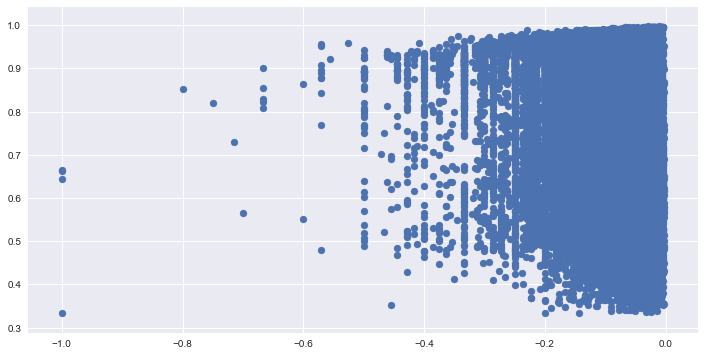

In [180]:
plt.figure(figsize=(12,6))
plt.scatter(food_quality['sentiment_score'], food_quality['food_quality'])

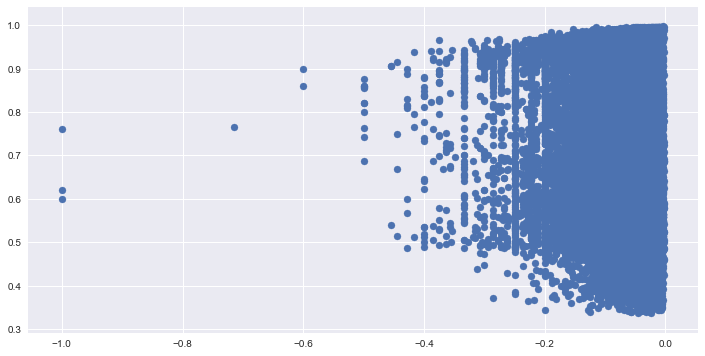

In [181]:
plt.figure(figsize=(12,6))
plt.scatter(price['sentiment_score'], price['price'])

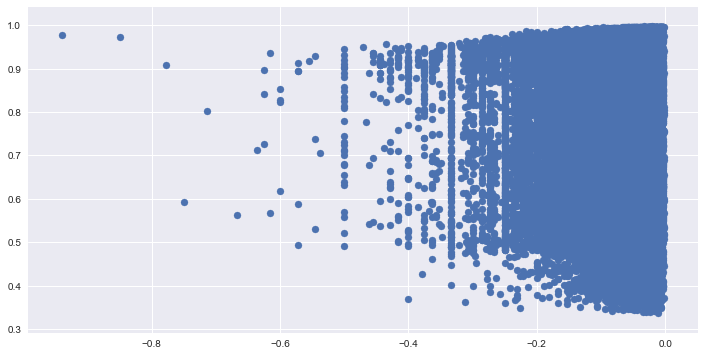

In [182]:
plt.figure(figsize=(12,6))
plt.scatter(service_quality['sentiment_score'], service_quality['service_quality'])

In [164]:
distplot2 = df_topics.loc[:,['sentiment_score', 'stars_dif', 'food_quality', 'price', 'service_quality', 'problem_type']]

In [165]:
distplot2.head()

,sentiment_score,stars_dif,food_quality,price,service_quality,problem_type
0,-0.033333,-2.67,0.968,0.016,0.016,0
1,-0.040000,-2.13,0.02,0.359,0.621,2
2,-0.040000,-0.48,0.964,0.018,0.017,0
3,-0.022989,-1.63,0.384,0.349,0.267,0
4,-0.057692,-1.21,0.271,0.41,0.319,1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


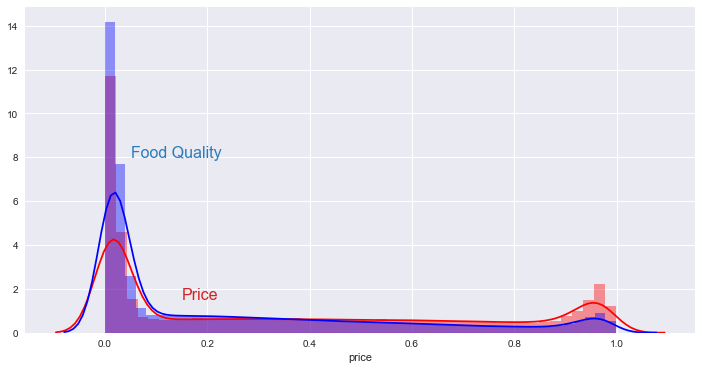

In [167]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(12,6))
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.distplot(distplot2['food_quality'], color="r")
ax = sns.distplot(distplot2['price'], color="b")


# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]

ax.text(0.05, 8.0, "Food Quality", size=16, color=blue)
ax.text(0.15, 1.5, "Price", size=16, color=red)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


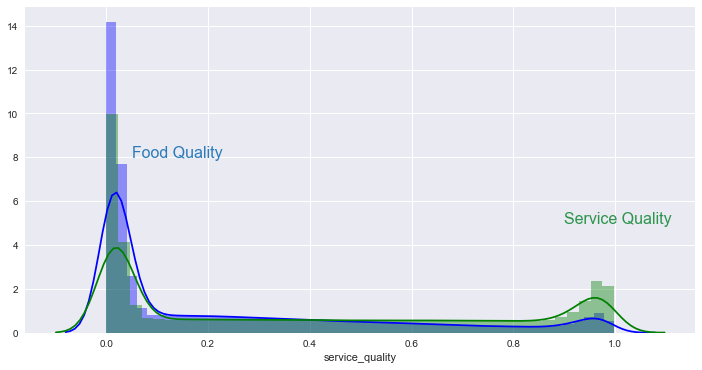

In [168]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(12,6))
#ax.set_aspect("equal")

# Draw the two density plots

ax = sns.distplot(distplot2['price'], color="b")
ax = sns.distplot(distplot2['service_quality'], color="g")

# Add labels to the plot

blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.05, 8.0, "Food Quality", size=16, color=blue)

ax.text(0.9, 5, "Service Quality", size=16, color=green)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


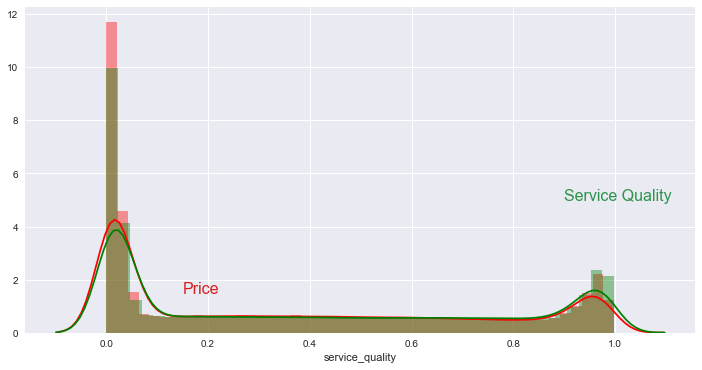

In [169]:
sns.set(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(12,6))
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.distplot(distplot2['food_quality'], color="r")

ax = sns.distplot(distplot2['service_quality'], color="g")

# Add labels to the plot
red = sns.color_palette("Reds")[-2]

green = sns.color_palette("Greens")[-2]

ax.text(0.15, 1.5, "Price", size=16, color=red)
ax.text(0.9, 5, "Service Quality", size=16, color=green)

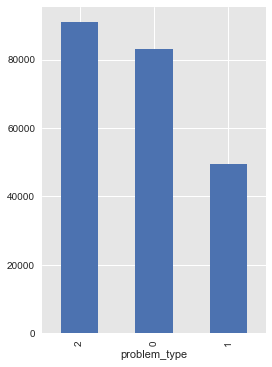

In [229]:
plt.figure(figsize=(4,6))
bar_df2 = distplot2.groupby('problem_type')['problem_type'].count().sort_values(ascending=False)
bar_df2.plot.bar()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


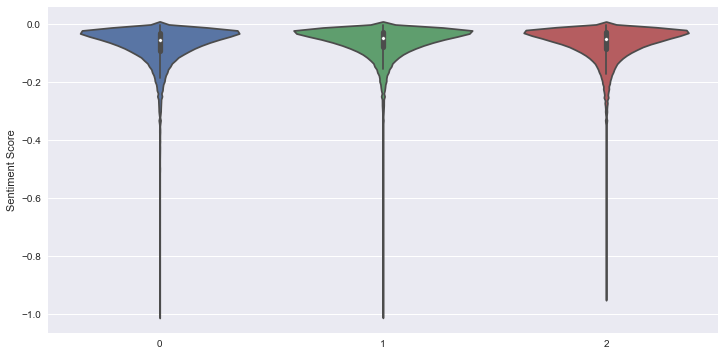

In [139]:
plt.figure(figsize=(12,6))
sns.violinplot(x='problem_type', y='sentiment_score', data=df_topics).set(xlabel='', ylabel='Sentiment Score')

In [ ]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.jointplot(distplot.stars_dif, distplot.sentiment_score, kind = 'kde', cmap="Reds", shade=True, shade_lowest=False)
sns.plt.ylim(-0.25,0)
sns.plt.xlim((-4),2)